# Прогноз оттока клиентов оператора связи

The telecom operator wants to combat customer churn. To do this, its employees will begin to offer promotional codes and special conditions to everyone who plans to refuse communication services. To find such users in advance, the telecom operator needs a model that will predict whether the subscriber will break the contract. The operator’s team collected personal data about some clients, information about their tariffs and services. Your task is to train a model on this data to predict customer churn.

<b>Описание данных</b>

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Файлы contract_new.csv, personal_new.csv, internet_new.csv, phone_new.csv
* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.
* MultipleLines — подключение телефона к нескольким линиям одновременно.

## Загрузка и предобработка данных

In [1]:
!pip install scikit-learn==1.1.3
!pip install -U xgboost

     |████████████████████████████████| 30.8 MB 2.5 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 297.1 MB 3.2 kB/s s eta 0:00:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.1
    Uninstalling xgboost-1.5.1:
      Successfully uninstalled xgboost-1.5.1


In [2]:
!pip install phik catboost lightgbm xgboost

     |████████████████████████████████| 679 kB 2.6 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, roc_curve, auc, confusion_matrix
from functools import reduce

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

RANDOM_STATE = 251223

In [4]:
# Создадим функцию для отображения базовой статистики

def analyze_datasets(names_list):
    for name in names_list:
        dataset = eval(name)
        print("-"*32)
        print("-"*32)
        print(f"Информация о датасете {name}:")
        print("-"*32)
        print("-"*32)
        print()
        print(dataset.info())
        print()

        print(f"Первые 5 строк:")
        print(dataset.head())
        print()

        print(f"Статистика:")
        print(dataset.describe(include='all'))
        print()

        print(f"Доля пропусков:")
        missing_values_count = dataset.isnull().sum()
        total_rows = len(dataset)
        missing_ratio = round((missing_values_count / total_rows) * 100, 2)
        print(missing_ratio)
        print()

        print(f"Количество дубликатов строк:",
              dataset.duplicated().sum())
        print()
        print()

In [5]:
# Загрузим данные

try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [6]:
# Изучим базовую статистику загруженных датасетов

analyze_datasets(['contract', 'personal', 'internet', 'phone'])

--------------------------------
--------------------------------
Информация о датасете contract:
--------------------------------
--------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Первые 5 строк:
   customerID   BeginDate EndDate            Type PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges
0  7590-VHVEG  2020-01-01      No  Month-to-month           

In [7]:
# Объединим датасеты

df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how="outer"), [contract, personal, internet, phone])

In [8]:
# Проанализируем объединенный датафрейм

analyze_datasets(['df'])

--------------------------------
--------------------------------
Информация о датасете df:
--------------------------------
--------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 n

In [9]:
# Приведем названия столбцов в snake_case

rename_columns = {
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies',
    'MultipleLines': 'multiple_lines'
}

df = df.rename(columns=rename_columns)

df.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [10]:
# Избавимся от пропусков меняя отсутствие информации об
# использовании интернета абонентом на no-internet
# использовании телефонной связи  абонентом на no-phone

columns_with_internet_service = [
    'internet_service', 'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies'
]

for column in columns_with_internet_service:
    df[column] = df[column].fillna('no-internet')

df['multiple_lines'] = df['multiple_lines'].fillna('no-phone')

print(df.isnull().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


In [11]:
# Изменим типы данных

df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'])

# Заменим строки с пропуском в total_charges на 0 и преобразуем во float

df['total_charges'] = df['total_charges'].replace(' ', 0)
df['total_charges'] = df['total_charges'].astype(float)

In [12]:
# Создадим столбцы со сроком существования абонента и бинарный (является ли
# абонент на текущий момент клиентом или нет)

df['duration'] = (df['end_date'] - df['begin_date']).dt.days
df['churn'] = df['end_date'].apply(lambda x: 0 if x == pd.to_datetime('2020-02-01') else 1)

<div class="alert" style="border: 1px solid; padding: 10px;">
<b><u>Промежуточные выводы:</u></b>
    
1. Загрузили данные, обратили внимание:
    
* датасеты contract и personal имеют одинаковое количество строк, а значит у нас есть полные данные по всем абонентам
* некоторые абоненты не пользуются мобильной связью, а некоторые интернетом. 
* полные дубликаты не выявлены

2. Объединили датасеты по уникальным id, предобработали данные:

* привели кодировку в соответствие для изучения и последующего моделирования
* заполнили пропуски в данных об использовании интернета и мобильной связи при помощи заглушек no-internet, no-phone
* Создали вспомогательные столбцы со сроком жизни абонента и целевым признаком churn где 1 - абонент ушел, 0 - абонент активен.  
* Удалим впоследствии столбцы c идентификатором абонента, полной датой, месяцем начала и датой конца действия договора как мало значимые данные. 
* На основании имеющихся данных создали признаки: срок существования абонента и целевой приизнак churn (0 - договор с абонентом активен, 1 - договор с абонентом расторгнут)
* Заменили пропуски в совокупных тратах на 0 чтобы иметь возможность прогнозировать в будущем всю выборку абонентов и не исключать "новых".
</div> 

## Изучение данных

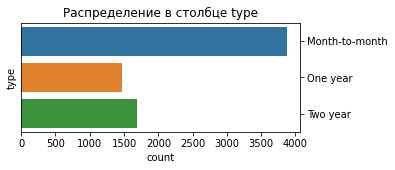

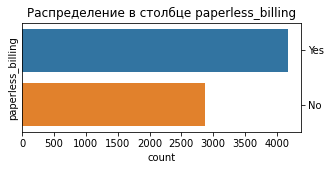

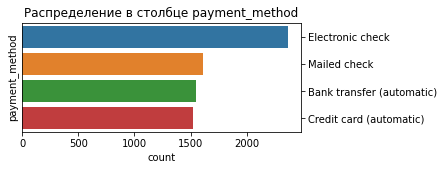

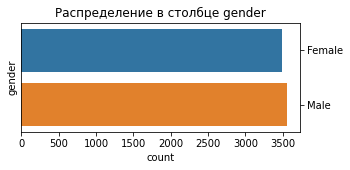

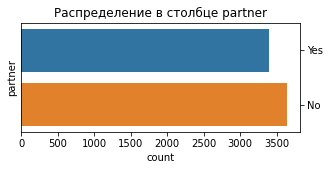

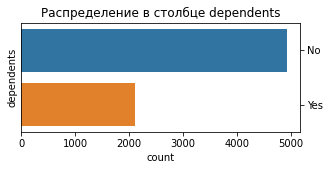

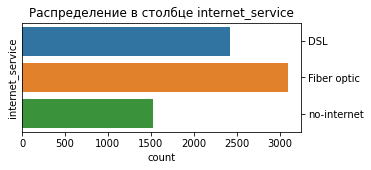

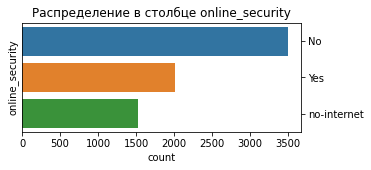

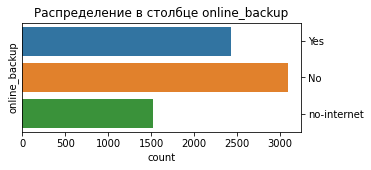

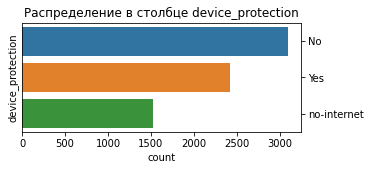

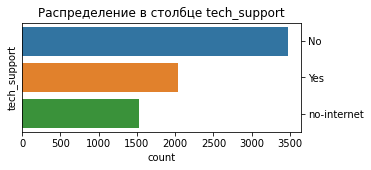

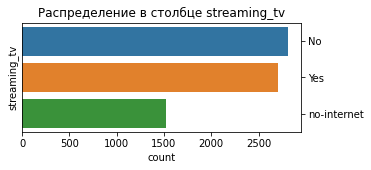

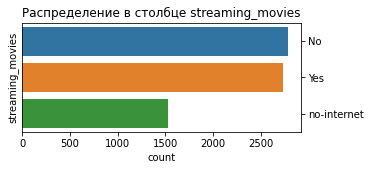

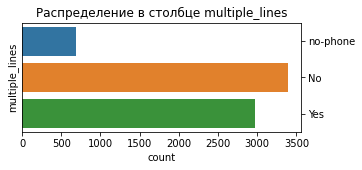

In [13]:
# Исследуем категориальные и бинарные столбцы

group = ['type', 'paperless_billing', 'payment_method', 'gender',
         'senior_citizen', 'partner', 'dependents', 'internet_service',
         'online_security', 'online_backup', 'device_protection',
         'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

df_filtered = df[group]

category_columns = df_filtered.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns.tolist()

for column in category_columns:
    plt.figure(figsize=(5, 2))
    sns.countplot(data=df, y=column)

    plt.tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

    plt.title(f'Распределение в столбце {column}')
    plt.show()

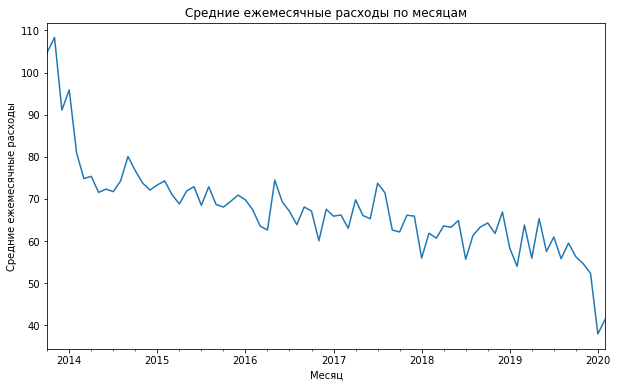

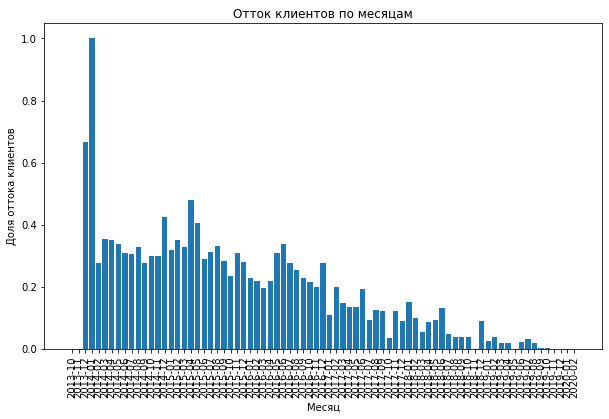

In [14]:
# Изучим временной ряд ежемесячных расходов

df['begin_month'] = df['begin_date'].dt.to_period('M')
monthly_expenses_mean = df.groupby('begin_month')['monthly_charges'].mean()

plt.figure(figsize=(10, 6))
monthly_expenses_mean.plot()
plt.title('Средние ежемесячные расходы по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средние ежемесячные расходы')
plt.show()

# Изучим отток клиентов по месяцам

churn_rate_by_month = df.groupby('begin_month')['churn'].mean()
plt.figure(figsize=(10, 6))
plt.bar(churn_rate_by_month.index.astype(str), churn_rate_by_month.values)
plt.title('Отток клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доля оттока клиентов')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Удалим ненужные столбцы

columns_to_drop = ['customer_id', 'begin_date', 
                   'end_date', 'begin_month']

existing_columns = set(df.columns)
columns_to_drop = [col for col in columns_to_drop if col in existing_columns]

if columns_to_drop:
    df.drop(columns=columns_to_drop, inplace=True)

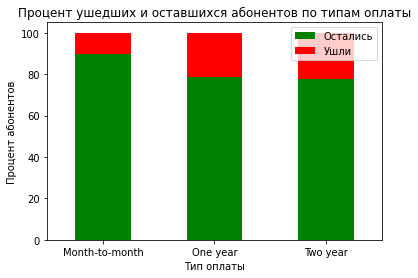

In [16]:
# Подсчитаем количество абонентов в каждой группе type и churn

type_churn_counts = df.groupby(['type', 'churn']).size().unstack()
type_churn_percentage = type_churn_counts.div(type_churn_counts.sum(axis=1), axis=0) * 100

type_churn_percentage.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Процент ушедших и оставшихся абонентов по типам оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Процент абонентов')
plt.legend(["Остались", "Ушли"], loc='upper right')
plt.xticks(rotation=0)  
plt.show()

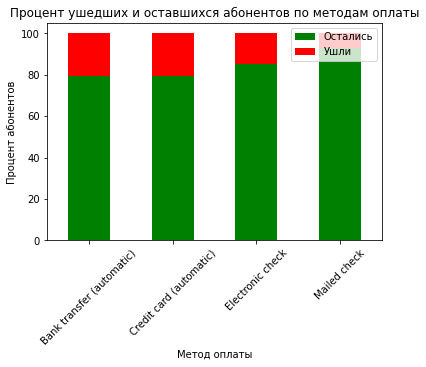

In [17]:
# Подсчитаем количество абонентов в каждой группе payment_method и churn

payment_churn_counts = df.groupby(['payment_method', 'churn']).size().unstack()
payment_churn_percentage = payment_churn_counts.div(payment_churn_counts.sum(axis=1), axis=0) * 100

payment_churn_percentage.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Процент ушедших и оставшихся абонентов по методам оплаты')
plt.xlabel('Метод оплаты')
plt.ylabel('Процент абонентов')
plt.legend(["Остались", "Ушли"], loc='upper right')
plt.xticks(rotation=45)
plt.show()

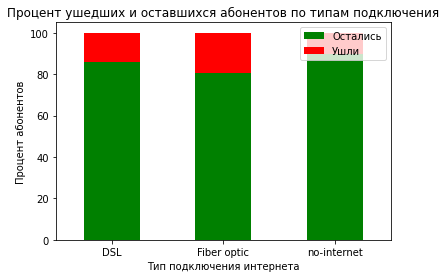

In [18]:
# Подсчитаем количество абонентов в каждой группе internet_service и churn

internet_service_churn_counts = df.groupby(['internet_service', 'churn']).size().unstack()
internet_service_churn_percentage = internet_service_churn_counts.div(internet_service_churn_counts.sum(axis=1), axis=0) * 100

internet_service_churn_percentage.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Процент ушедших и оставшихся абонентов по типам подключения')
plt.xlabel('Тип подключения интернета')
plt.ylabel('Процент абонентов')
plt.legend(["Остались", "Ушли"], loc='upper right')
plt.xticks(rotation=0)
plt.show()

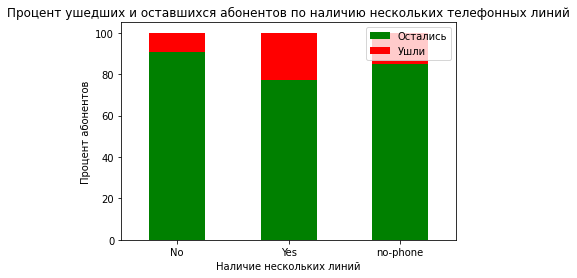

In [19]:
# Подсчитаем количество абонентов в каждой группе multiple_lines и churn

multiple_lines_churn_counts = df.groupby(['multiple_lines', 'churn']).size().unstack()
multiple_lines_churn_percentage = multiple_lines_churn_counts.div(multiple_lines_churn_counts.sum(axis=1), axis=0) * 100

multiple_lines_churn_percentage.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Процент ушедших и оставшихся абонентов по наличию нескольких телефонных линий')
plt.xlabel('Наличие нескольких линий')
plt.ylabel('Процент абонентов')
plt.legend(["Остались", "Ушли"], loc='upper right')
plt.xticks(rotation=0)
plt.show()

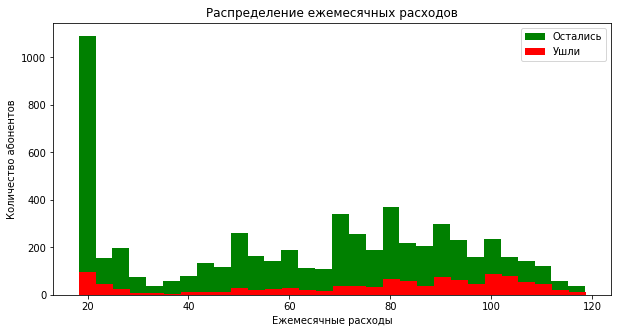

In [20]:
# Построем гистограмму monthly_charges

plt.figure(figsize=(10, 5))
plt.hist(df[df['churn'] == 0]['monthly_charges'], bins=30, label='Остались', color='green')
plt.hist(df[df['churn'] == 1]['monthly_charges'], bins=30, label='Ушли', color='red')
plt.title('Распределение ежемесячных расходов')
plt.xlabel('Ежемесячные расходы')
plt.ylabel('Количество абонентов')
plt.legend()
plt.show()

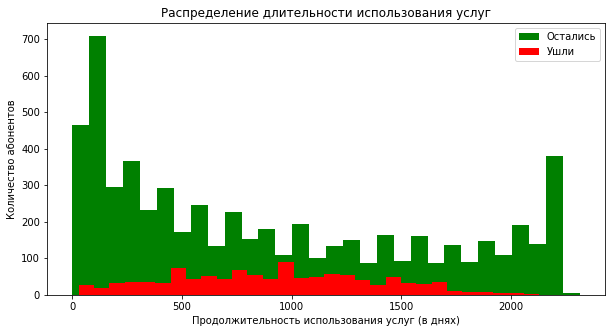

In [21]:
# Построим гистограмму duration

plt.figure(figsize=(10, 5))
plt.hist(df[df['churn'] == 0]['duration'], bins=30, label='Остались', color='green')
plt.hist(df[df['churn'] == 1]['duration'], bins=30, label='Ушли', color='red')
plt.title('Распределение длительности использования услуг')
plt.xlabel('Продолжительность использования услуг (в днях)')
plt.ylabel('Количество абонентов')
plt.legend()
plt.show()

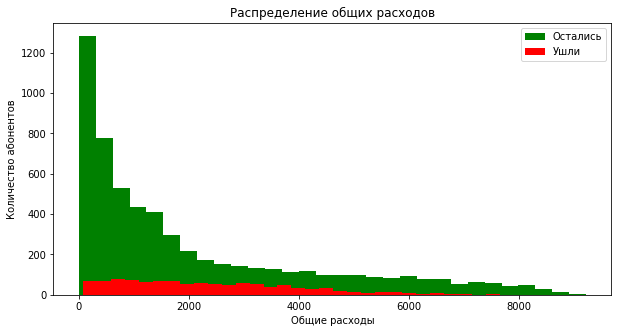

In [22]:
# Построем гистограмму total_charges

plt.figure(figsize=(10, 5))
plt.hist(df[df['churn'] == 0]['total_charges'], bins=30, label='Остались', color='green')
plt.hist(df[df['churn'] == 1]['total_charges'], bins=30, label='Ушли', color='red')
plt.title('Распределение общих расходов')
plt.xlabel('Общие расходы')
plt.ylabel('Количество абонентов')
plt.legend()
plt.show()

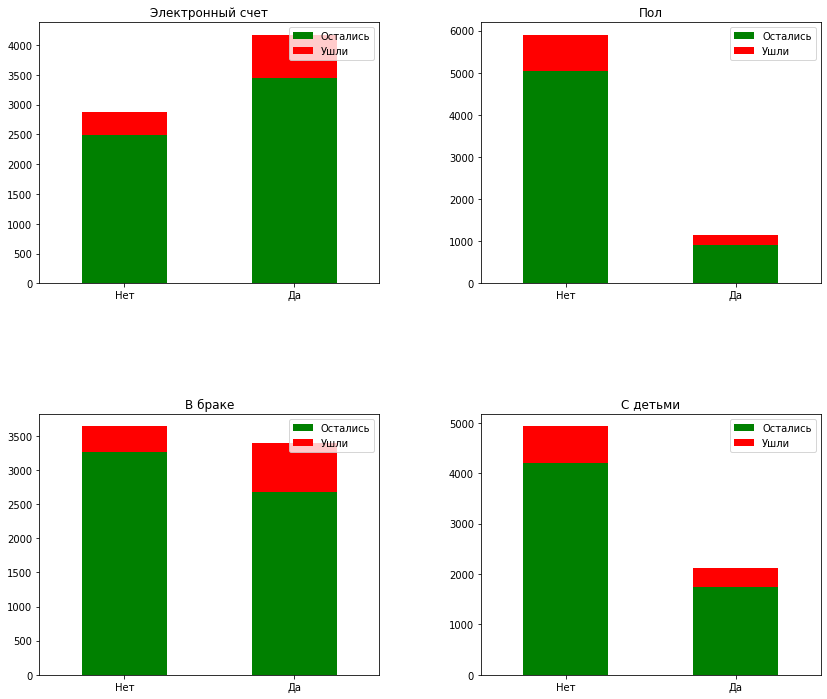

In [23]:
features = ['paperless_billing', 'senior_citizen', 'partner', 'dependents']
feature_labels = ['Электронный счет', 'Пол', 'В браке', 'С детьми']

n_rows = 2
n_cols = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for index, (feature, label) in enumerate(zip(features, feature_labels)):
    ax = axes[index // n_cols, index % n_cols]
    churn_counts = df.groupby([feature, 'churn']).size().unstack()
    churn_counts.plot(kind='bar', ax=ax, color=['green', 'red'], stacked=True)
    ax.set_title(label)
    ax.set_xlabel('')
    ax.set_xticklabels(['Нет', 'Да'], rotation=0)
    ax.legend(["Остались", "Ушли"], loc='upper right')

plt.show()

In [24]:
# Закодируем столбцы с бинарными признаками в 0 и 1

if df['gender'].dtype == 'object':
  df['gender'] = df['gender'].map({'Female': 0, 'Male': 1}).astype(int)
if df['paperless_billing'].dtype == 'object':
  df['paperless_billing'] = df['paperless_billing'].map({'No': 0, 'Yes': 1}).astype(int)
if df['partner'].dtype == 'object':
  df['partner'] = df['partner'].map({'No': 0, 'Yes': 1}).astype(int)
if df['dependents'].dtype == 'object':
  df['dependents'] = df['dependents'].map({'No': 0, 'Yes': 1}).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   int64  
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   int64  
 8   dependents         7043 non-null   int64  
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

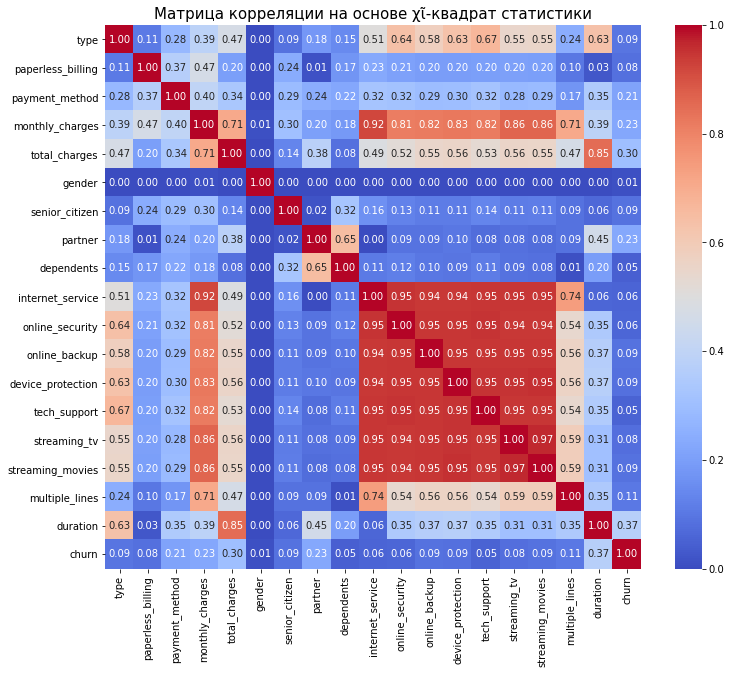

In [25]:
# Построим матрицу корреляций
# Cоздадим два набора данных - интервальный и категориальный

interval_cols = ['monthly_charges', 'total_charges', 'duration']

categorical_columns = ['paperless_billing', 'gender', 'senior_citizen',
                       'partner', 'dependents', 'churn',
                       'type', 'payment_method', 'internet_service',
                       'online_security', 'online_backup',
                       'device_protection', 'tech_support',
                       'streaming_tv', 'streaming_movies', 'multiple_lines']

for col in categorical_columns:
    df[col] = df[col].astype('category')

phik_matrix = df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции на основе χῖ-квадрат статистики', fontsize=15)
plt.show()

In [26]:
# Удалим gender

df = df.drop('gender', axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               7043 non-null   category
 1   paperless_billing  7043 non-null   category
 2   payment_method     7043 non-null   category
 3   monthly_charges    7043 non-null   float64 
 4   total_charges      7043 non-null   float64 
 5   senior_citizen     7043 non-null   category
 6   partner            7043 non-null   category
 7   dependents         7043 non-null   category
 8   internet_service   7043 non-null   category
 9   online_security    7043 non-null   category
 10  online_backup      7043 non-null   category
 11  device_protection  7043 non-null   category
 12  tech_support       7043 non-null   category
 13  streaming_tv       7043 non-null   category
 14  streaming_movies   7043 non-null   category
 15  multiple_lines     7043 non-null   category
 16  durati

<div class="alert" style="border: 1px solid; padding: 10px;">
<b><u>Промежуточные выводы по данным:</u></b>

* При анализе данных мы столкнулись с большим количеством категориальных признаков в том числе бинарных.
* На матрице phik заметна мультиколлинеарность столбцов internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies друг с другом, а также со столбцом monthly_charges. Столбец gender вообще никак не коррелирует. Эти значения при моделировании следует удалить для улучшения точности модели логистической модели.
* Перевели бинарные значения в 0 и 1.


<b><u>Промежуточные выводы по графикам:</u></b>
* Электронные способы оплаты и выставления счетов являются наиболее популярными среди абонентов.
* Подключения к интернету с использованием оптоволокна наиболее популярны, что может указывать на предпочтение более высокоскоростного интернета абонентами.
* Ежегодная и двухгодичная оплата связаны с более высоким процентом оттока по сравнению с ежемесячной оплатой. Это может говорить о том, что долгосрочные абоненты более склонны уйти.
* Существует постепенное снижение средних ежемесячных расходов абонентов, это может сигнализировать о том, что компания снижает цены для удержания клиентов или привлечения новых в условиях повышенной конкуренции на рынке.
* Процент оттока клиентов падает от года к году, однако, высокий процент ухода клиентов, использующих автоматическое списание это плохой сигнал, так как такие абоненты наиболее лояльные и удобные.
* Среди дополнительных услуг, наибольшей популярностью обладают услуги блокировки опасных сайтов. Мало абонентов используют резервное копирование, что может указывать на недостаток осведомленности в данной услуге.
* С увеличением срока активного договора вероятность того, что абонент уйдет уменьшается.
* Существует корреляция между графиком ежемесячных расходов текущих абонентов и графиком расходов ушедших, что может свидетельствовать о том, что решение уйти не обязательно связано с уровнем расходов. Возможно, в оттоке клиентов играет роль неудовлетворенность сервисом, качество связи или другие факторы, не связанные непосредственно с ценой услуг.
</div>

## Подготовка данных к обучению

In [28]:
# Создадим матрицу признаков и вектор целевой переменной

X = df.drop('churn', axis=1)
y = df['churn']

In [29]:
# Проверим таргет на дисбаланс классов

class_distribution = (y.value_counts() / y.shape[0]) * 100
print(class_distribution)

0    84.367457
1    15.632543
Name: churn, dtype: float64


In [30]:
# Создадим для бустинговых моделей тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

In [31]:
# Создадим выборки для логистической регрессии

X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [32]:
# Избавимся от мультиколлинеарности

columns_to_drop = ['internet_service', 'total_charges', 'online_security',
                   'online_backup', 'device_protection', 'tech_support',
                   'streaming_tv', 'streaming_movies']
X_train_lr = X_train_lr.drop(columns=columns_to_drop)
X_test_lr = X_test_lr.drop(columns=columns_to_drop)

In [33]:
# Кодируем категориальные признаки

encoder = OneHotEncoder(drop='first',
                        handle_unknown='ignore',
                        sparse=False)
categorical_columns = ['type', 'paperless_billing', 'payment_method',
                       'senior_citizen', 'partner',
                       'dependents', 'multiple_lines']

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train_lr[categorical_columns]),
                               columns=encoder.get_feature_names_out(categorical_columns),
                               index=X_train_lr.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test_lr[categorical_columns]),
                              columns=encoder.get_feature_names_out(categorical_columns),
                              index=X_test_lr.index)

X_train_final = pd.concat([X_train_lr.drop(columns=categorical_columns),
                           X_train_encoded], axis=1)
X_test_final = pd.concat([X_test_lr.drop(columns=categorical_columns),
                          X_test_encoded], axis=1)

In [34]:
# Масштабируем числовые признаки

scaler = StandardScaler()
numeric_columns = ['monthly_charges', 'duration']

X_train_final[numeric_columns] = scaler.fit_transform(X_train_final[numeric_columns])
X_test_final[numeric_columns] = scaler.transform(X_test_final[numeric_columns])

In [35]:
# Создадим категориальные и количественные наборы столбцов

cat_columns = ['paperless_billing', 'senior_citizen',
               'partner', 'dependents', 'type', 'payment_method',
                'internet_service', 'online_security', 'online_backup',
               'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies', 'multiple_lines']
num_columns = ['monthly_charges', 'total_charges', 'duration']

In [36]:
# Изучим размеры выборок

print("Размеры выборок:")
print("X:", X.shape)
print("y:", y.shape)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

Размеры выборок:
X: (7043, 17)
y: (7043,)
X_train: (5282, 17)
X_test: (1761, 17)
y_train: (5282,)
y_test: (1761,)
X_train_final: (5282, 13)
X_test_final: (1761, 13)


<div class="alert" style="border: 1px solid; padding: 10px;">
<b><u>Промежуточные выводы:</u></b>
    
* Для логистической регрессии избавились от мультиколлинеарности
* Создали матрицу признаков и вектор целевой переменной
* Проверили и заметили дисбаланс классов, но так как целевая метрика ROC-AUC устойчива к дисбалансу, то предпринимать ничего с ним не будем.
* Создали выборки для логистической регрессии и бустинговых моделей.
* Для логистической регресии закодировали OHE категориальные признаки и масштабировали числовые признаки.
* Для случайного леса произведем кодирование OrdinalEncoder при обучении модели.
* Для бустинговых моделей определили категориальные столбцы.
* Проверили размеры получившихся выборок. 
</div>

## Обучение моделей

In [37]:
 results = []

In [38]:
#####################################################################
#                                                                   #
#     param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}      #
#                                                                   #
#####################################################################

param_grid_lr = {'C': [1000]}

model_lasso = LogisticRegression(penalty='l1',
                                 solver='liblinear',
                                 random_state=RANDOM_STATE,
                                 max_iter=1000)
gs_lasso = GridSearchCV(model_lasso,
                        param_grid=param_grid_lr,
                        cv=5,
                        scoring='roc_auc',
                        refit=True)
gs_lasso.fit(X_train_final, y_train)

best_lasso_model = gs_lasso.best_estimator_
best_params = gs_lasso.best_params_
best_score = round(gs_lasso.best_score_, 2)
print("Лучшие параметры:", best_params)
print()
print("Лучший ROC-AUC LASSO на train:", best_score)

results.append({'Модель': best_lasso_model.__class__.__name__,
                'ROC-AUC': best_score,
                'mod': best_lasso_model,
                'test': X_test_final})

Лучшие параметры: {'C': 1000}

Лучший ROC-AUC LASSO на train: 0.75


In [39]:
#####################################################################
#                                                                   #
#     param_grid = {                                                #
#        'model__n_estimators': [50, 100, 150],                     #
#        'model__max_depth': [2, 5, 7, 10],                         #
#        'model__min_samples_split': [20],                          #
#        'model__min_samples_leaf': [3]}                            #
#                                                                   #
#####################################################################

param_grid_rf = {
    'model__max_depth': [7],
    'model__min_samples_leaf': [3],
    'model__min_samples_split': [20],
    'model__n_estimators': [150],
}

model_rf = RandomForestClassifier(random_state=RANDOM_STATE,
                                  class_weight='balanced')

preprocessor = ColumnTransformer(
    [('ordinal', OrdinalEncoder(), cat_columns)],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model_rf)])

gs_rf = GridSearchCV(pipeline,
                     param_grid=param_grid_rf,
                     cv=5,
                     scoring='roc_auc',
                     refit=True)

gs_rf.fit(X_train, y_train)

best_rf_model = gs_rf.best_estimator_
best_params = gs_rf.best_params_
best_score = round(gs_rf.best_score_, 2)
print("Лучшие параметры:", best_params)
print()
print("Лучший ROC-AUC RandomForest на train:", best_score)

result_row = {'Модель': best_rf_model.named_steps['model'].__class__.__name__,
              'ROC-AUC': best_score,
              'mod': best_rf_model,
              'test': X_test}
results.append(result_row)

Лучшие параметры: {'model__max_depth': 7, 'model__min_samples_leaf': 3, 'model__min_samples_split': 20, 'model__n_estimators': 150}

Лучший ROC-AUC RandomForest на train: 0.82


In [40]:
#####################################################################
#                                                                   #
#     param_grid = {                                                #
#       'iterations': [100, 200, 600],                              #
#       'depth': [4, 6, 8],                                         #
#       'learning_rate': [0.01, 0.1],                               #
#       'l2_leaf_reg': [1, 3, 5]}                                   #
#                                                                   #
#####################################################################

param_grid_cb = {
    'iterations': [200],
    'depth': [8],
    'learning_rate': [0.1],
    'l2_leaf_reg': [1]
}

model_cb = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    verbose=False,
    auto_class_weights='Balanced',
    cat_features=cat_columns
)

gs_cb = GridSearchCV(
    model_cb,
    param_grid=param_grid_cb,
    cv=5,
    scoring='roc_auc',
    refit=True,
    verbose=1,
    error_score='raise'
)

gs_cb.fit(X_train, y_train)

best_cb_model = gs_cb.best_estimator_
best_params = gs_cb.best_params_
best_score = round(gs_cb.best_score_, 2)
print()
print("Лучшие параметры CatBoost:", best_params)
print()
print("Лучший ROC-AUC CatBoost на train:", best_score)

result_row = {'Модель': best_cb_model.__class__.__name__,
              'ROC-AUC': best_score,
              'mod': best_cb_model,
              'test': X_test}
results.append(result_row)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Лучшие параметры CatBoost: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

Лучший ROC-AUC CatBoost на train: 0.85


In [41]:
#####################################################################
#                                                                   #
#     param_grid_lgb = {                                            #
#       'learning_rate': [0.01, 0.1, 0.2],                          #
#       'num_leaves': [200, 300, 400],                              #
#       'max_depth': [20, 30, 40, 50],                              #
#       'boosting_type': ['gbdt', 'dart']}                          #
#                                                                   #
#####################################################################

param_grid_lgb = {
    'learning_rate': [0.1],
    'num_leaves': [200],
    'max_depth': [20],
    'boosting_type': ['dart']}

model_lgb = lgb.LGBMClassifier(
    objective='binary',
    data_sample_strategy='goss',
    verbosity=-1,
    random_state=RANDOM_STATE)

gs_lgb = GridSearchCV(
    model_lgb,
    param_grid=param_grid_lgb,
    cv=5,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1)

gs_lgb.fit(X_train,
           y_train,
           categorical_feature=cat_columns)

best_lgb_model = gs_lgb.best_estimator_
best_params_lgb = gs_lgb.best_params_
best_score = round(gs_lgb.best_score_, 2)
print("Лучшие параметры для LightGBM:", best_params_lgb)
print()
print("Лучший ROC-AUC LightGBM на train:", best_score)

result_row = {'Модель': best_lgb_model.__class__.__name__,
              'ROC-AUC': best_score,
              'mod': best_lgb_model,
              'test': X_test}
results.append(result_row)

[LightGBM] [Warning] Unknown parameter: data_sample_strategy
[LightGBM] [Warning] Unknown parameter: data_sample_strategy
[LightGBM] [Warning] Unknown parameter: data_sample_strategy
[LightGBM] [Warning] Unknown parameter: data_sample_strategy
[LightGBM] [Warning] Unknown parameter: data_sample_strategy
[LightGBM] [Warning] Unknown parameter: data_sample_strategy
Лучшие параметры для LightGBM: {'boosting_type': 'dart', 'learning_rate': 0.1, 'max_depth': 20, 'num_leaves': 200}

Лучший ROC-AUC LightGBM на train: 0.82


In [42]:
#####################################################################
#                                                                   #
#     param_grid_xgb = {                                            #
#       'max_depth': [3, 5, 7, 10],                                 #
#       'reg_alpha': [0.1, 0.5],                                    #
#       'min_child_weight': [1, 5, 10],                             #
#       'learning_rate': [0.01, 0.1],                               #
#       'n_estimators': [100, 200, 300]}                            #
#                                                                   #
#####################################################################

X_train_xgb = xgb.DMatrix(X_train,
                        label=y_train,
                        enable_categorical=True).get_data()
X_test_xgb = xgb.DMatrix(X_test,
                       label=y_test,
                       enable_categorical=True).get_data()

param_grid_xgb = {
    'max_depth': [5],
    'reg_alpha': [0.5],
    'min_child_weight': [1],
    'learning_rate': [0.1],
    'n_estimators': [300]}

model_xgb = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    objective='binary:logistic',
    eval_metric='logloss')

gs_xgb = GridSearchCV(
    model_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring = 'roc_auc',
    refit=True,
    verbose=1)

gs_xgb.fit(X_train_xgb, y_train)

best_xgb_model = gs_xgb.best_estimator_
best_params_xgb = gs_xgb.best_params_
best_score = round(gs_xgb.best_score_, 2)
print()

print("Лучшие параметры для XGBoost:", best_params_xgb)
print()
print("Лучший ROC-AUC XGBoost на train:", best_score)

result_row = {'Модель': best_xgb_model.__class__.__name__,
              'ROC-AUC': best_score,
              'mod': best_xgb_model,
              'test': X_test_xgb}
results.append(result_row)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.5}

Лучший ROC-AUC XGBoost на train: 0.89


In [43]:
# Изучаем результаты моделирования

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
df_results[['Модель', 'ROC-AUC']]

,Модель,ROC-AUC
0,XGBClassifier,0.89
1,CatBoostClassifier,0.85
2,RandomForestClassifier,0.82
3,LGBMClassifier,0.82
4,LogisticRegression,0.75


In [44]:
# Возьмем лучшую модель

best_model_info = df_results.iloc[0]
best_model_name = best_model_info['Модель']
best_model = best_model_info['mod']
test = best_model_info['test']

In [45]:
# Проведем тестирование лучшей модели

y_test_proba = best_model.predict_proba(test)[:, 1]
roc_auc = round(roc_auc_score(y_test, y_test_proba), 2)
accuracy = round(accuracy_score(y_test, best_model.predict(test)), 2)

In [46]:
# Выведем результаты

print(f"Тестирование лучшей модели {best_model_name} дает результат:")
print(f"ROC-AUC: {roc_auc}")
print(f"Accuracy: {accuracy}")

Тестирование лучшей модели XGBClassifier дает результат:
ROC-AUC: 0.92
Accuracy: 0.9


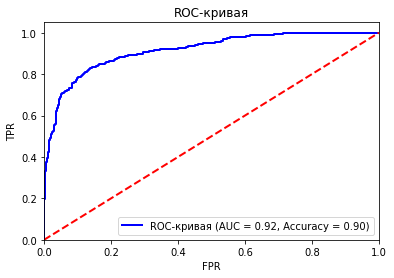

In [47]:
# Вычислим FPR, TPR и построим кривую

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC-кривая (AUC = %0.2f, Accuracy = %0.2f)' % (roc_auc_val, accuracy))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

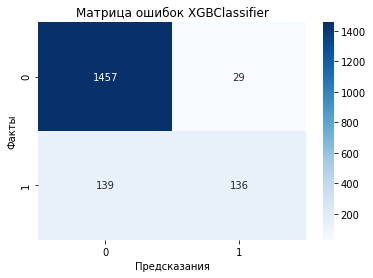

In [48]:
# Построим матрицу ошибок

y_pred = best_model.predict(test)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказания')
plt.ylabel('Факты')
plt.title(f'Матрица ошибок {best_model_name}')
plt.show()

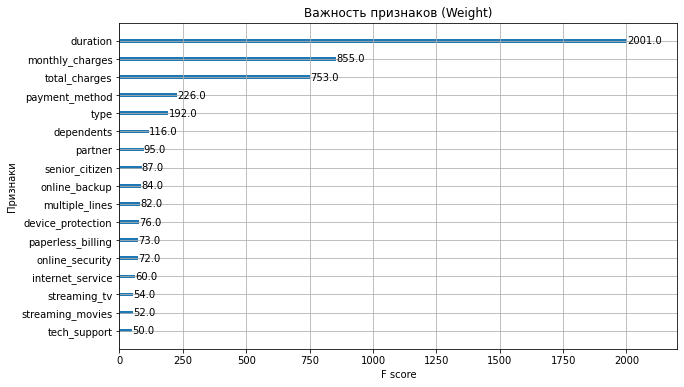

In [49]:
# Построим диаграммы важности признаков

feature_names = X_train.columns.tolist()
best_model.get_booster().feature_names = feature_names

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Weight
xgb.plot_importance(best_model, importance_type='weight', ax=axes)
axes.set_title('Важность признаков (Weight)')
axes.set_ylabel('Признаки')
plt.show()

<div class="alert" style="border: 1px solid; padding: 10px;">
<b><u>Промежуточные выводы:</u></b><br>

1. <b>Результаты тестирования лучшей модели:</b>
* XGBClassifier на тесте дал результаты ROC-AUC - 0.92, Accuracy - 0.9

2. <b>Матрица ошибок</b>
* Accuracy = (TP + TN) / (TP + FP + FN + TN)<br>
Accuracy = 90.46%
* Precision = TP / (TP + FP)<br>
Precision = 82.42%
* Recall = TP / (TP + FN)<br>
Recall = 49.45%

В условии задачи явно указано требование максимизации ROC-AUC - она является основной метрикой для оценки производительности модели, поэтому остальные метрики  рассчитаны справочно так как при дисбалансе классов могут вводить в заблуждение.

3. <b>Веса признаков</b>
* duration является наиболее часто используемым признаком, за ним следуют monthly_charges, total_charges, payment_metod и type.
</div>

## Общий вывод

### Список признаков, участвующих в обучении модели и описание их предобработки

<div class="alert" style="border: 1px solid; padding: 10px;">
<b><u>При обучении моделей были использованы следующие признаки</u></b>

* Для логистической регрессии: monthly_charges, duration, type, paperless_billing, payment_method, senior_citizen, partner, dependents, multiple_lines
* Для бустинговых моделей и случайного леса: type, paperless_billing, payment_method, monthly_charges, total_charges, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines, duration


<b><u>Признаки были обработаны по следующему принципу</u></b>

* Для логистической регрессии из матрицы признаков была устранена мультиколлинеарность путем удаления столбцов, кодирование OHE и масштабирование.
* Для бустинговых моделей и случайного леса производилась замена бинарных признаков на 0 и 1.
* Для случайного леса производилось кодирование OrdinalEncoder.
* Для бустинговых моделей определены категориальные столбцы.
</div>

### Итоговая модель с гиперпараметрами и значение метрики на тестовой выборке

<div class="alert" style="border: 1px solid; padding: 10px;">
    
1. <b>Лучшая модель XGBoost</b>

2. <b>Лучшие гиперпараметры</b>
* learning_rate = 0.1
* max_depth = 5
* min_child_weight = 1
* n_estimators = 300
* reg_alpha = 0.5
* random_state = 251223
* objective = binary:logistic
* eval_metric = logloss

3. <b>Результат тестирования модели</b>
* ROC-AUC: 0.92 (условие задания было получить модель с результатом => 0.88 на тесте)

</div>

### Заказчику следует

<div class="alert" style="border: 1px solid; padding: 10px;">

<b>Внедрить предложенную модель, которая будет отслеживать метрики и выявлять тренды. Оперативно реагировать на изменения в поведении клиентов и динамике рынка. Принимать более обоснованные решения в управлении клиентским опытом и маркетинговыми стратегиями</b>.

* Рассмотреть возможность инвестиций в улучшение инфраструктуры оптоволокна, поскольку большое количество абонентов используют это подключение к интернету, и высокий процент оттока в этой группе может быть сигналом о неудовлетворенности качеством услуги.
* Высокий процент оттока среди абонентов, использующих автоматическое списание с дебетовых и кредитных карт говорит о серьезном недовольстве так как автоматическое списание предпочитают достаточно лояльные клиенты.
* Поскольку доля оттока клиентов падает от года к году, оператору стоит тщательно изучить и применить успешные меры по удержанию клиентов, использованные в прошлые периоды, а также определить основные факторы, которые способствовали этому снижению.
* Высокая доля оттока среди абонентов, оплачивающих услуги раз в 2 года, может указывать на то, что оператору следует разработать более привлекательные программы лояльности или предложения для удержания долгосрочных клиентов.
* Так как процент оттока выше для абонентов с несколькими телефонными номерами в договоре, то стоит рассмотреть вопросы качества обслуживания или ценообразования.
* Большинство абонентов имеют детей, что может повышать востребованность услуг по блокировке опасных сайтов и родительский контроль. 
* Следует повышать информированность абонентов о пользе услуги резервного копирования и стимулировать её более широкое использование для увеличения среднего чека.
* С учетом доли семейных абонентов следует сфокусироваться на разработке пакетных предложений для членов семьи.
</div>